# Understanding the Amazon from Space
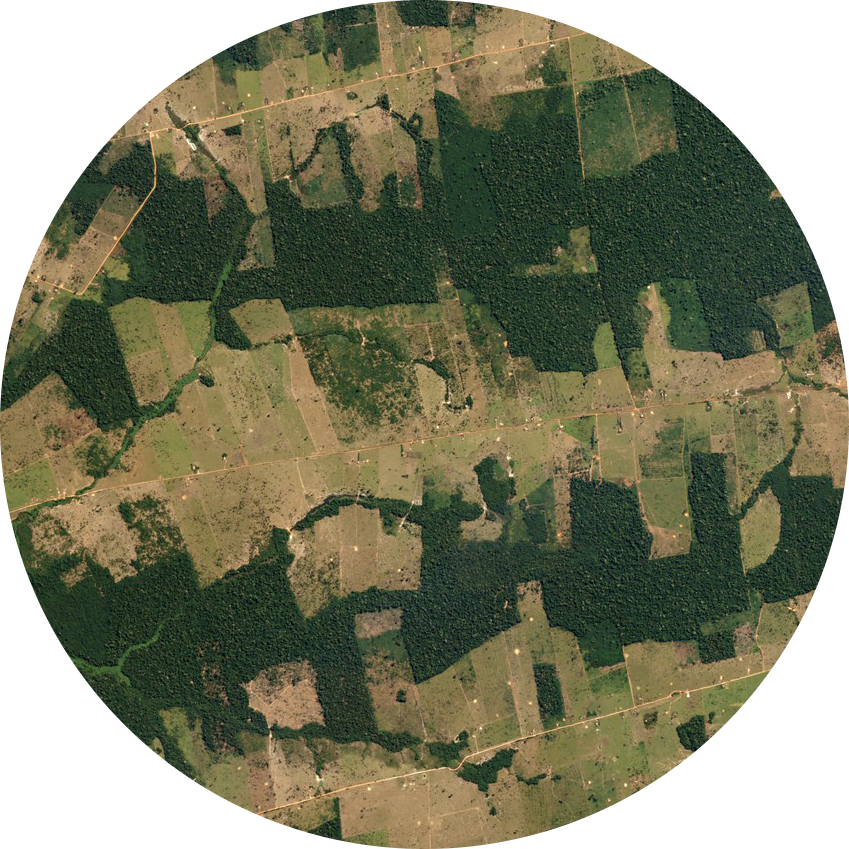

Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.

Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate.

In this project, the aim is to label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.

### Importing Modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras as kr
from keras.models import Sequential
from keras.layers import Flatten, Dropout, Dense
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.metrics import fbeta_score
from os import listdir

In [2]:
# Load data
train = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
# Getting unique tags
train_val = train['tags'].values
split = [x.split(' ') for x in train_val]
lst = []
for sublst in split:
    lst += sublst
labels = list(set(lst))
labels

['partly_cloudy',
 'cloudy',
 'clear',
 'habitation',
 'slash_burn',
 'haze',
 'conventional_mine',
 'cultivation',
 'blow_down',
 'blooming',
 'agriculture',
 'bare_ground',
 'road',
 'artisinal_mine',
 'selective_logging',
 'water',
 'primary']

In [4]:
# Mapping tags
dic = {}
for x, y in enumerate(labels):
    dic[y] = x
dic

{'partly_cloudy': 0,
 'cloudy': 1,
 'clear': 2,
 'habitation': 3,
 'slash_burn': 4,
 'haze': 5,
 'conventional_mine': 6,
 'cultivation': 7,
 'blow_down': 8,
 'blooming': 9,
 'agriculture': 10,
 'bare_ground': 11,
 'road': 12,
 'artisinal_mine': 13,
 'selective_logging': 14,
 'water': 15,
 'primary': 16}

### Preview Some image

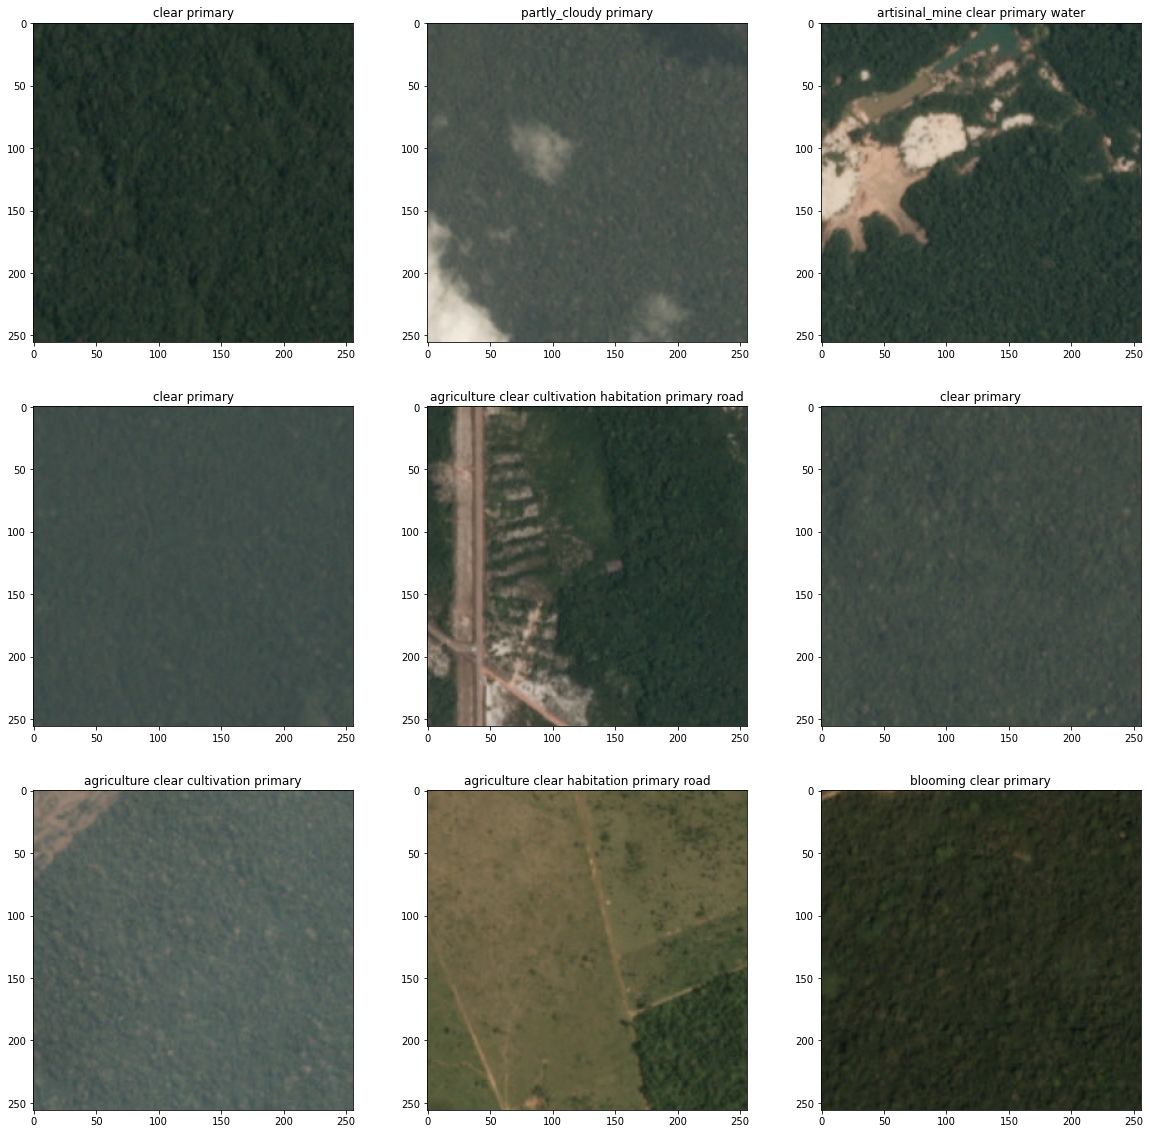

In [5]:
fig,ax = plt.subplots(3,3, figsize = (20,20))
for i,j in enumerate(np.random.randint(0,train.shape[0],9)):
    image_path = '/kaggle/input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(str(j))
    img = cv2.imread(image_path)
    ax[int(i/3),i%3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[int(i/3),i%3].set_title(train.iloc[j,1])

### Image encoding and processing

In [6]:
x_train = []
y_train = []

for x, tags in tqdm(train.values, miniters=1500):
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(x))
    targets = np.zeros(17)
    for tag in tags.split(' '):
        targets[dic[tag]] = 1
    x_train.append(cv2.resize(img, (32,32)))
    y_train.append(targets)

y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [07:26<00:00, 90.62it/s] 


(40479, 32, 32, 3)
(40479, 17)


### Splitting data

In [7]:
split = 33000
x_train, x_test, y_train, y_test = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

### First Model Training

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                activation='relu',
                input_shape=(32,32,3)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
             optimizer='adam',
             metrics=['accuracy'])

2023-01-13 00:19:51.301720: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
history = model.fit(x_train, y_train,
             batch_size=128,
             epochs=6,
             verbose=1,
             validation_data=(x_test, y_test))


2023-01-13 00:19:52.239215: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6
258/258 [==============================] - 38s 144ms/step - loss: 0.2552 - accuracy: 0.0405 - val_loss: 0.2034 - val_accuracy: 0.0202
Epoch 2/6
258/258 [==============================] - 37s 142ms/step - loss: 0.2074 - accuracy: 0.0420 - val_loss: 0.1918 - val_accuracy: 0.0516
Epoch 3/6
258/258 [==============================] - 38s 145ms/step - loss: 0.1938 - accuracy: 0.0606 - val_loss: 0.1767 - val_accuracy: 0.0675
Epoch 4/6
258/258 [==============================] - 37s 142ms/step - loss: 0.1846 - accuracy: 0.0814 - val_loss: 0.1727 - val_accuracy: 0.0457
Epoch 5/6
258/258 [==============================] - 37s 142ms/step - loss: 0.1780 - accuracy: 0.0954 - val_loss: 0.1651 - val_accuracy: 0.0650
Epoch 6/6
258/258 [==============================] - 37s 143ms/step - loss: 0.1745 - accuracy: 0.1082 - val_loss: 0.1607 - val_accuracy: 0.0825


### Evaluate Model

In [10]:
valid = model.predict(x_test, batch_size=128)
print(fbeta_score(y_test, np.array(valid) > 0.2, beta=2, average='samples'))

0.8487899424347339


### Visualize Loss

Text(0.5, 1.0, 'Loss Curves - before tweaking')

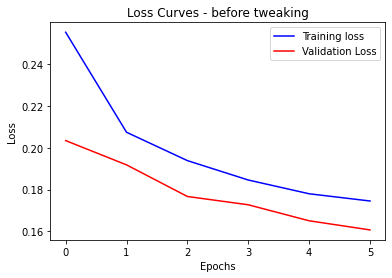

In [11]:
plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - before tweaking')

### Second Model Training (Add more layers)

In [12]:
model = Sequential()
# Block 1
model.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(32, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

#Block 2
model.add(Conv2D(64, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

#Block 3
model.add(Conv2D(128, (3,3), input_shape=(128,128,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(128, (3,3), activation='relu',
                padding='same', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(17, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(x_train, y_train,
                 batch_size=128,
                 epochs=6,
                 verbose=1,
                 validation_data=(x_test, y_test))


Epoch 1/6
258/258 [==============================] - 70s 270ms/step - loss: 0.2083 - accuracy: 0.0594 - val_loss: 0.1697 - val_accuracy: 0.0955
Epoch 2/6
258/258 [==============================] - 71s 274ms/step - loss: 0.1573 - accuracy: 0.0950 - val_loss: 0.1538 - val_accuracy: 0.1542
Epoch 3/6
258/258 [==============================] - 69s 266ms/step - loss: 0.1449 - accuracy: 0.1168 - val_loss: 0.1427 - val_accuracy: 0.0956
Epoch 4/6
258/258 [==============================] - 69s 267ms/step - loss: 0.1369 - accuracy: 0.1214 - val_loss: 0.1393 - val_accuracy: 0.0995
Epoch 5/6
258/258 [==============================] - 69s 266ms/step - loss: 0.1289 - accuracy: 0.1294 - val_loss: 0.1279 - val_accuracy: 0.1633
Epoch 6/6
258/258 [==============================] - 69s 268ms/step - loss: 0.1242 - accuracy: 0.1308 - val_loss: 0.1307 - val_accuracy: 0.1650


### Evaluate Model

In [14]:
valid = model.predict(x_test, batch_size=128)
print(fbeta_score(y_test, np.array(valid) > 0.2, beta=2, average='samples'))

0.8815834870189909


### Visualize Loss

Text(0.5, 1.0, 'Loss Curves - after tweaking')

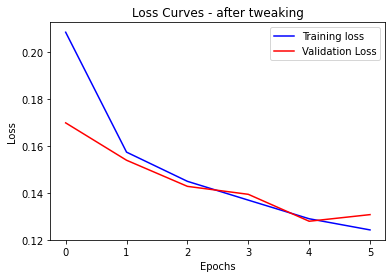

In [15]:
plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - after tweaking')

### Implement Model on test data 

In [16]:
x_test = []
x_test_add = []
img_title = []
img_title_add = []

for x in tqdm(listdir('/kaggle/input/planets-dataset/planet/planet/test-jpg'), miniters=1500):
    img_name = x.split('.')[0]
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (32,32)))
    img_title.append(img_name)
    
for x in tqdm(listdir('/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional'), miniters=1500):
    img_name = x.split('.')[0]
    img = cv2.imread('/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img_name))
    x_test_add.append(cv2.resize(img, (32,32)))
    img_title_add.append(img_name)
    
x_test = np.array(x_test, np.float16) / 255
x_test_add = np.array(x_test_add, np.float16) / 255
    


100%|██████████| 20522/20522 [03:18<00:00, 103.50it/s]


In [17]:
pred1 = model.predict(x_test, batch_size=128)
pred2 = model.predict(x_test_add, batch_size=128)

In [18]:
image1 = []
tags1 = []
for i, img in enumerate(img_title):
    image1.append(img)
    tags1.append(' '.join(np.array(labels)[pred1[i] > 0.2]))
df1 = pd.DataFrame()
df1['image_name'] = image1
df1['tags'] = tags1

image2 = []
tags2 = []
for i, img in enumerate(img_title_add):
    image2.append(img)
    tags2.append(' '.join(np.array(labels)[pred2[i] > 0.2]))
df2 = pd.DataFrame()
df2['image_name'] = image2
df2['tags'] = tags2

In [19]:
full_df = pd.concat([df1, df2])
full_df

,image_name,tags
0,test_39140,partly_cloudy clear cultivation agriculture ro...
1,test_4849,clear haze primary
2,test_18979,clear habitation cultivation agriculture road ...
3,test_24790,clear agriculture road water primary
4,test_30624,clear primary
...,...,...
20517,file_6101,partly_cloudy primary
20518,file_7113,clear primary
20519,file_9271,clear agriculture road water primary
20520,file_13908,clear habitation cultivation agriculture road ...


### Save to submission file

In [20]:
full_df.to_csv('submission.csv', index=False)

In [21]:
pd.read_csv('/kaggle/working/submission.csv')

,image_name,tags
0,test_39140,partly_cloudy clear cultivation agriculture ro...
1,test_4849,clear haze primary
2,test_18979,clear habitation cultivation agriculture road ...
3,test_24790,clear agriculture road water primary
4,test_30624,clear primary
...,...,...
61186,file_6101,partly_cloudy primary
61187,file_7113,clear primary
61188,file_9271,clear agriculture road water primary
61189,file_13908,clear habitation cultivation agriculture road ...
